In [405]:
from sodapy import Socrata
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
import retrieval_311

In [2]:
path = "data/311_Cases.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
ssc_df = df[df['Category']=='Street and Sidewalk Cleaning'].copy()

In [5]:
ssc_df['Opened'] = pd.to_datetime(ssc_df['Opened'])
ssc_df['hour'] = ssc_df['Opened'].dt.hour
ssc_df['minute'] = ssc_df['Opened'].dt.minute
ssc_df['day'] = ssc_df['Opened'].dt.day
ssc_df['year'] = ssc_df['Opened'].dt.year
ssc_df['Month'] = ssc_df['Opened'].dt.month

In [6]:
# Should read this to CSV so I don't have to do it again

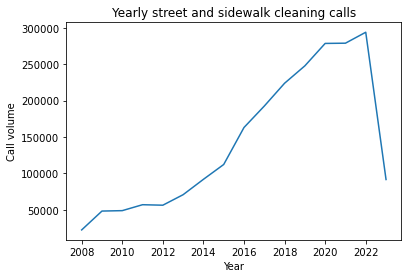

In [7]:
ssc_df['year'].value_counts().sort_index().plot()
plt.title("Yearly street and sidewalk cleaning calls")
plt.xlabel("Year")
plt.ylabel("Call volume")
plt.show()

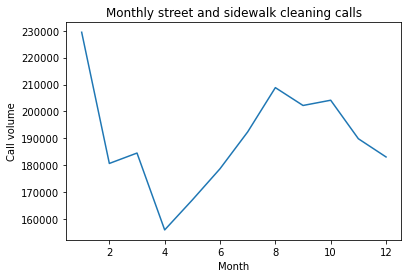

In [8]:
ssc_df['Month'].value_counts().sort_index().plot()
plt.title("Monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

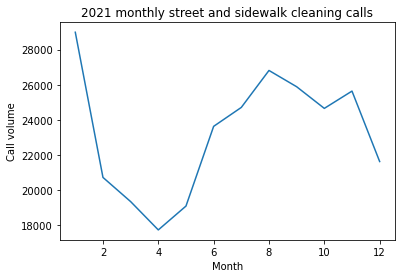

In [9]:
df_2021 = ssc_df[ssc_df['year']==2021]
df_2021['Month'].value_counts().sort_index().plot()
plt.title("2021 monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

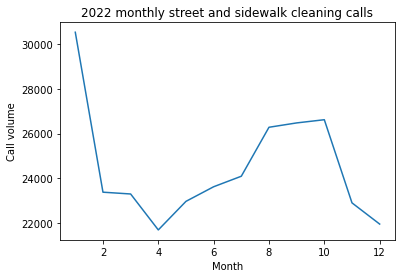

In [10]:
df_2022 = ssc_df[ssc_df['year']==2022]
df_2022['Month'].value_counts().sort_index().plot()
plt.title("2022 monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

## ARIMA

In [11]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [12]:
ssc_df['RoundTime'] = ssc_df['Opened'].apply(hour_rounder)

In [13]:
hourly_count = ssc_df.groupby('RoundTime')['CaseID'].count()

In [14]:
hourly_count

RoundTime
2008-07-01 00:00:00     2
2008-07-01 03:00:00     1
2008-07-01 05:00:00     3
2008-07-01 06:00:00     7
2008-07-01 07:00:00     5
                       ..
2023-04-04 21:00:00    28
2023-04-04 22:00:00    15
2023-04-04 23:00:00     7
2023-04-05 00:00:00    11
2023-04-05 01:00:00    10
Name: CaseID, Length: 112319, dtype: int64

In [15]:
first_date = np.min(hourly_count.index)
last_date = np.max(hourly_count.index)
# This works for hour
# for i in range(24):
#     print("0"+str(i)+":00:00")

# for i in range(10):
#     print(hourly_count.index[0])


curr_hour = hourly_count.index[0].to_pydatetime()
all_hours = []
i = 0
while (curr_hour + timedelta(hours=i)) != (last_date.to_pydatetime() + timedelta(hours=1)):
#     if curr_hour == last_date.to_pydatetime():
#         print("Finished")
#         break
    all_hours.append(curr_hour + timedelta(hours=i))
    i+=1
    if i % 1000 ==0:
        print(i)
    if i>130000:
        break
    if curr_hour == last_date.to_pydatetime():
        print("Finished")
        break

# print(all_hours)



# for i in range(len(hourly_count.index)):    
#     print(hourly_count.index[0].to_pydatetime() + timedelta(hours=i))
#     all_hours.append()
#     pass

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000


In [16]:
all_hours = pd.DataFrame(np.array(all_hours))
all_hours.columns=['Hours']

In [17]:
# all_hours
full_hourly_count = pd.merge(all_hours, hourly_count, left_on='Hours', right_on=['RoundTime'], how='outer').fillna(0)
# full_hourly_count = full_hourly_count.set_index('Hours')

In [18]:
full_hourly_count

Hours  CaseID
0      2008-07-01 00:00:00     2.0
1      2008-07-01 01:00:00     0.0
2      2008-07-01 02:00:00     0.0
3      2008-07-01 03:00:00     1.0
4      2008-07-01 04:00:00     0.0
...                    ...     ...
129381 2023-04-04 21:00:00    28.0
129382 2023-04-04 22:00:00    15.0
129383 2023-04-04 23:00:00     7.0
129384 2023-04-05 00:00:00    11.0
129385 2023-04-05 01:00:00    10.0

[129386 rows x 2 columns]

In [19]:
print(full_hourly_count['Hours'][0])
# full_hourly_count['Year'] = 
full_hourly_count['Hours'] = pd.to_datetime(full_hourly_count['Hours'])
full_hourly_count['Year'] = full_hourly_count['Hours'].dt.year
full_hourly_count['Month'] = full_hourly_count['Hours'].dt.month
full_hourly_count['Day'] = full_hourly_count['Hours'].dt.day
full_hourly_count['Hour'] = full_hourly_count['Hours'].dt.hour

2008-07-01 00:00:00


In [20]:
full_hourly_count['CaseID']

0          2.0
1          0.0
2          0.0
3          1.0
4          0.0
          ... 
129381    28.0
129382    15.0
129383     7.0
129384    11.0
129385    10.0
Name: CaseID, Length: 129386, dtype: float64

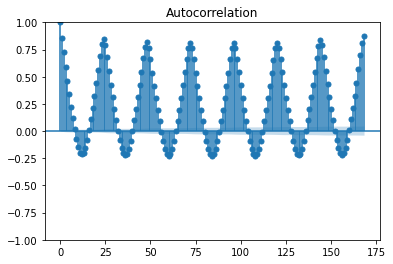

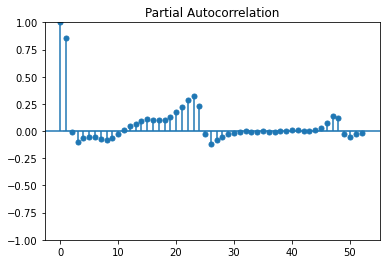

In [398]:
plot_acf(full_hourly_count['CaseID'].values.astype(float), lags=168, alpha=0.05)
plt.savefig('figures/ARIMA_autocorrelation', dpi=300)
plot_pacf(full_hourly_count['CaseID'].values.astype(float), method='ywm')
plt.savefig('figures/ARIMA_partial_autocorrelation', dpi=300)
plt.show();

In [22]:
# Implement train test split here - probably remove this
X = full_hourly_count['CaseID'].values
# Doing an 80/20 split
split = int(len(X) * 0.80)
train, test = X[:split], X[split:]
train_dates, test_dates = full_hourly_count.index[:split], full_hourly_count.index[split:]

### 2021 predict 2022 ARIMA (24,1,0)

In [23]:
data_2021 = full_hourly_count[full_hourly_count['Year']==2021]
data_2021

data_2022 = full_hourly_count[full_hourly_count['Year']==2022]
data_2022

Hours  CaseID  Year  Month  Day  Hour
118368 2022-01-01 00:00:00    10.0  2022      1    1     0
118369 2022-01-01 01:00:00     6.0  2022      1    1     1
118370 2022-01-01 02:00:00     5.0  2022      1    1     2
118371 2022-01-01 03:00:00     1.0  2022      1    1     3
118372 2022-01-01 04:00:00    11.0  2022      1    1     4
...                    ...     ...   ...    ...  ...   ...
127123 2022-12-31 19:00:00     6.0  2022     12   31    19
127124 2022-12-31 20:00:00     5.0  2022     12   31    20
127125 2022-12-31 21:00:00     5.0  2022     12   31    21
127126 2022-12-31 22:00:00    11.0  2022     12   31    22
127127 2022-12-31 23:00:00     1.0  2022     12   31    23

[8760 rows x 6 columns]

In [377]:
# Need to convert this to using Peter's script
new_df = retrieval_311.process_data()

Data available locally
Processing data


In [381]:
new_df.head()

calls  month  dayofweek  dayofmonth  hourofday
datetime                                                           
2008-07-01 00:00:00      2      7          1           1          0
2008-07-01 01:00:00      1      7          1           1          1
2008-07-01 02:00:00      1      7          1           1          2
2008-07-01 03:00:00      1      7          1           1          3
2008-07-01 04:00:00      1      7          1           1          4

In [371]:
full_hourly_count

Hours  CaseID  Year  Month  Day  Hour  CaseID_norm
0      2008-07-01 00:00:00     2.0  2008      7    1     0    -0.683493
1      2008-07-01 01:00:00     0.0  2008      7    1     1    -0.771132
2      2008-07-01 02:00:00     0.0  2008      7    1     2    -0.771132
3      2008-07-01 03:00:00     1.0  2008      7    1     3    -0.727312
4      2008-07-01 04:00:00     0.0  2008      7    1     4    -0.771132
...                    ...     ...   ...    ...  ...   ...          ...
129381 2023-04-04 21:00:00    28.0  2023      4    4    21     0.455818
129382 2023-04-04 22:00:00    15.0  2023      4    4    22    -0.113837
129383 2023-04-04 23:00:00     7.0  2023      4    4    23    -0.464395
129384 2023-04-05 00:00:00    11.0  2023      4    5     0    -0.289116
129385 2023-04-05 01:00:00    10.0  2023      4    5     1    -0.332936

[129386 rows x 7 columns]

In [334]:
# model=ARIMA()
# params = {}
# cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True)
# cv_model.fit(X_train, y_train)
# model = cv_model.best_estimator_
# model.fit(X_train, y_train)

# GridSearchCV()


# model = auto_arima(data_2021['CaseID'].values, start_p=1, start_q=1,
#                            max_p=26, max_q=2, m=1,
#                            seasonal=True,
#                            d=0, trace=True,
#                            error_action='warn',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(model.aic())

# model.fit(data_2021['CaseID'].values)

# prediction1 = model.predict(n_periods=len(data_2021['CaseID'].values))
# prediction2 = model.predict(n_periods=len(data_2022['CaseID'].values))

In [337]:
def tune_arima_hyperparams(data, forecast_length, p, d):
    '''
    Inputs:
        data
        p - max order of autoregressive model to evaluate
        d - max degree of differencing to evaluate
    Outputs:
        aic_array - numpy array of maic of each model evaluated
        mse_array - numpy array of mse of each model evaluated
        optimal_order - tuple, values of p,d,q that resulted in lowest mse
        forecast - 
    '''
    aic_array = np.ones((p,d))
    mse_array = np.ones((p,d))
    order_array = []
    for i in range(p):
        for j in range(d):
            model = ARIMA(data, order=(i+1,j+1,0))
            model_fit = model.fit()
            aic_array[i][j] = model_fit.aic
            mse_array[i][j] = model_fit.mse
            order_array.append(model.order)
            print(model.order)
            print(model_fit.aic)
            print("------------")

    optimal_order = order_array[np.argmin(mse_array)]
    best_model = ARIMA(data, order=optimal_order)
    model_fit = best_model.fit()
    print(model_fit.summary())
    forecast = model_fit.predict(end=forecast_length)
    return aic_array, mse_array, optimal_order, forecast

In [ ]:
aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=data_2021['CaseID'].values, forecast_length=len(data_2022)-1, p=24, d=2)

In [338]:
aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=data_2021['CaseID'].values, \
                                                                       forecast_length=len(data_2022)-1, \
                                                                       p=48, \
                                                                       d=2)

(1, 1, 0)
78488.01822976553
------------
(1, 2, 0)
82511.56790486372
------------
(2, 1, 0)
78444.78118095003
------------
(2, 2, 0)
81440.3538711008
------------
(3, 1, 0)
78423.26772351036
------------
(3, 2, 0)
80788.34905875647
------------
(4, 1, 0)
78415.28152195444
------------
(4, 2, 0)
80375.08329994984
------------
(5, 1, 0)
78409.35880865299
------------
(5, 2, 0)
80079.50897817206
------------
(6, 1, 0)
78406.35710611002
------------
(6, 2, 0)
79871.4978001672
------------
(7, 1, 0)
78402.80014642612
------------
(7, 2, 0)
79749.72671186586
------------
(8, 1, 0)
78388.19469495006
------------
(8, 2, 0)
79671.25587295971
------------
(9, 1, 0)
78361.16366401187
------------
(9, 2, 0)
79632.81346650334
------------
(10, 1, 0)
78301.61870304665
------------
(10, 2, 0)
79607.47058993966
------------
(11, 1, 0)
78215.05142724572
------------
(11, 2, 0)
79594.16018812529
------------
(12, 1, 0)
78080.25212801197
------------
(12, 2, 0)
79580.66571768046
------------
(13, 1, 0)
7

/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(47, 1, 0)
73243.67714395806
------------
(47, 2, 0)
73989.52871725634
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(48, 1, 0)
73245.5786111849
------------
(48, 2, 0)
73921.90602493915
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8760
Model:                ARIMA(48, 1, 0)   Log Likelihood              -36573.789
Date:                Mon, 01 May 2023   AIC                          73245.579
Time:                        14:14:15   BIC                          73592.393
Sample:                             0   HQIC                         73363.751
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5520      0.003   -203.958      0.000      -0.557      -0.547
ar.L2         -0.5895      0.004   -133.043      0.000      -0.598      -0.581
ar.L3         -0.5600      0.010    -54.715      0.0

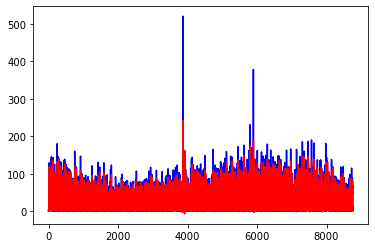

In [339]:
plt.plot(data_2021['CaseID'].values, c='b')
plt.plot(forecast, c='r')

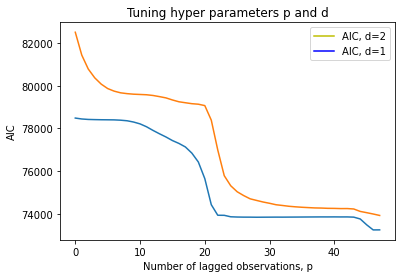

In [340]:
plt.plot(aic_array)
plt.plot([], c='y', label='AIC, d=2')
plt.plot([], c='b', label='AIC, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("AIC")
plt.title("Tuning hyper parameters p and d")
plt.legend()
plt.show();

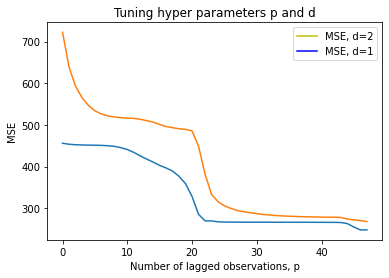

In [341]:
plt.plot(mse_array)
plt.plot([], c='y', label='MSE, d=2')
plt.plot([], c='b', label='MSE, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("MSE")
plt.title("Tuning hyper parameters p and d")
plt.legend()
plt.show();

In [342]:
# I actually think 24,2,0 is better RMSE than 24,1,0 - investigate

rmse = np.sqrt(mean_squared_error(forecast, data_2022['CaseID']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.872


In [343]:
# Now trying p=72
data = data_2021['CaseID'].values
order = (72,1,0)
model = ARIMA(data, order=order)
model_fit = model.fit()
print(model_fit.summary())
len(data_2022)-1
forecast = model_fit.predict(end=forecast_length)

/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8760
Model:                ARIMA(72, 1, 0)   Log Likelihood              -36441.971
Date:                Mon, 01 May 2023   AIC                          73029.942
Time:                        14:31:33   BIC                          73546.624
Sample:                             0   HQIC                         73205.994
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5731      0.003   -175.165      0.000      -0.580      -0.567
ar.L2         -0.6126      0.005   -124.196      0.000      -0.622      -0.603
ar.L3         -0.5744      0.011    -53.800      0.0

NameError: name 'forecast_length' is not defined

In [344]:
forecast = model_fit.predict(end=len(data_2022)-1)

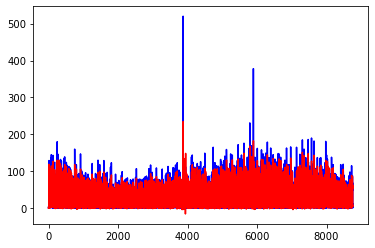

In [346]:
plt.plot(data_2021['CaseID'].values, c='b')
plt.plot(forecast, c='r')

In [347]:
# I actually think 24,2,0 is better RMSE than 24,1,0 - investigate

rmse = np.sqrt(mean_squared_error(forecast, data_2022['CaseID']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.714


In [370]:
# Now trying p=168 for 1 week - DONT USE THIS, IT TAKES TOO LONG
# curr_time = time.time()
# data = data_2021['CaseID'].values
# order = (168,1,0)
# model = ARIMA(data, order=order)
# model_fit = model.fit()
# print(model_fit.summary())
# forecast_length = len(data_2022)-1
# forecast = model_fit.predict(end=forecast_length)
# plt.plot(data_2021['CaseID'].values, c='b')
# plt.plot(forecast, c='r')
# rmse = np.sqrt(mean_squared_error(forecast, data_2022['CaseID']))
# print('Test RMSE: %.3f' % rmse)
# print('Time Taken: %.3f' % (curr_time - time.time()))

In [127]:
# aic_list = []
# mse_list = []


# aic_array = np.ones((24,2))
# mse_array = np.ones((24,2))
# order_array = []
# for i in range(24):
#     for j in range(2):
#         model = ARIMA(data_2021['CaseID'].values, order=(i+1,j+1,0))
#         model_fit = model.fit()
#         print(model_fit.aic)
#         aic_array[i][j] = model_fit.aic
#         mse_array[i][j] = model_fit.mse
#         order_array.append(model.order)
#         print(model.order)
#         print((i+1, j+1))


# best_model = ARIMA(data_2021['CaseID'].values, order=(np.argmin(mse_list)+1,1,0))
# model_fit = model.fit()
# print(model_fit.summary())
# forecast = model_fit.predict(end=len(data_2022)-1)

In [128]:
# Since the mse_array is 24x2, need to divide by 2 and round in order to get proper index
# order = order_array[np.argmin(mse_array)]
# best_model = ARIMA(data_2021['CaseID'].values, order=order)
# model_fit = best_model.fit()
# print(model_fit.summary())
# forecast = model_fit.predict(end=len(data_2022)-1)

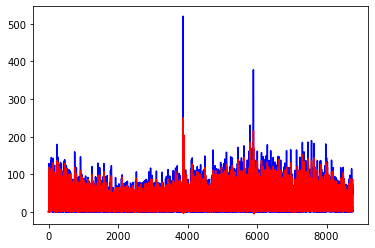

In [118]:
plt.plot(data_2021['CaseID'].values, c='b')
plt.plot(forecast, c='r')

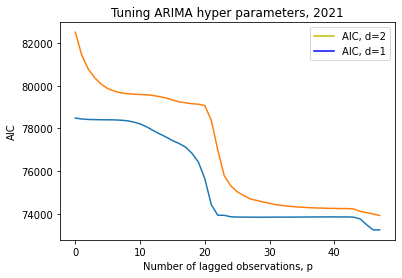

In [392]:
plt.plot(aic_array)
plt.plot([], c='y', label='AIC, d=2')
plt.plot([], c='b', label='AIC, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("AIC")
plt.title("Tuning ARIMA hyper parameters, 2021")
plt.legend()
plt.savefig('figures/ARIMA_AIC', dpi=300)
plt.show();

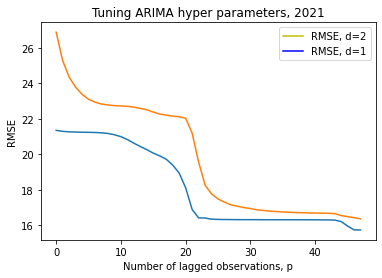

In [391]:
# plt.plot(mse_array)
plt.plot(np.sqrt(mse_array))
plt.plot([], c='y', label='RMSE, d=2')
plt.plot([], c='b', label='RMSE, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("RMSE")
plt.title("Tuning ARIMA hyper parameters, 2021")
plt.legend()
plt.savefig('figures/ARIMA_RMSE', dpi=300)
plt.show();

In [121]:
# I actually think 24,2,0 is better RMSE than 24,1,0 - investigate

rmse = np.sqrt(mean_squared_error(forecast, data_2022['CaseID']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.367


In [407]:
r2 = r2_score(forecast, data_2022['CaseID'])
print('Test R^2: %.3f' % r2)

Test R^2: 0.623


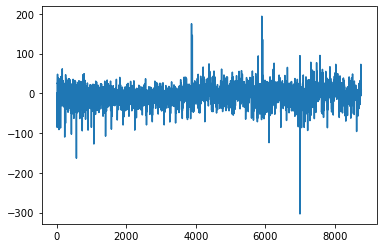

In [122]:
plt.plot(forecast-data_2022['CaseID'].values)
plt.show();

In [408]:
np.max(np.abs((forecast - data_2022['CaseID'].values)))

304.75337809814016

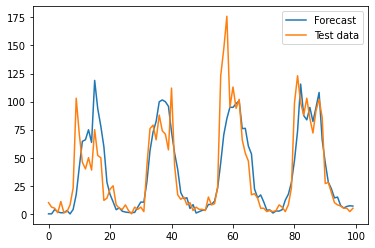

In [123]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(data_2022['CaseID'].values[:100], label='Test data')
plt.legend();

<AxesSubplot:>

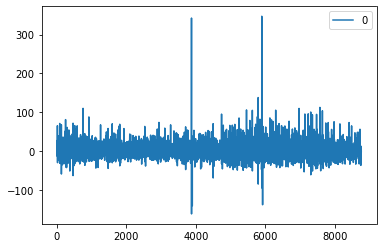

In [124]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

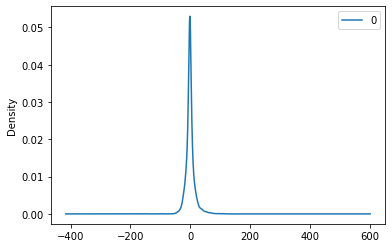

In [125]:
residuals.plot(kind='kde')

In [126]:
residuals.describe()

0
count  8760.000000
mean     -0.000943
std      16.417495
min    -161.780552
25%      -6.223838
50%      -1.170156
75%       4.160331
max     347.368069

### Do it for all years

In [237]:
scaler = StandardScaler()
curr_year_data = full_hourly_count[full_hourly_count['Year']==2021]['CaseID'].values
print(curr_year_data)
print(curr_year_data.shape)
normalized_data = scaler.fit_transform(curr_year_data.reshape(-1,1)).reshape(-1)
print(normalized_data)
scaler.inverse_transform(normalized_data.reshape(-1,1)).reshape(-1)

[ 0.  4.  2. ...  1. 12.  8.]
(8760,)
[-0.97718062 -0.85435565 -0.91576814 ... -0.94647438 -0.6087057
 -0.73153068]


array([-3.55271368e-15,  4.00000000e+00,  2.00000000e+00, ...,
        1.00000000e+00,  1.20000000e+01,  8.00000000e+00])

In [254]:
full_hourly_count['CaseID']

0          2.0
1          0.0
2          0.0
3          1.0
4          0.0
          ... 
129381    28.0
129382    15.0
129383     7.0
129384    11.0
129385    10.0
Name: CaseID, Length: 129386, dtype: float64

In [258]:
full_hourly_count['CaseID_norm'] = scaler.fit_transform(full_hourly_count['CaseID'].values.reshape(-1,1)).reshape(-1)

In [259]:
full_hourly_count

Hours  CaseID  Year  Month  Day  Hour  CaseID_norm
0      2008-07-01 00:00:00     2.0  2008      7    1     0    -0.683493
1      2008-07-01 01:00:00     0.0  2008      7    1     1    -0.771132
2      2008-07-01 02:00:00     0.0  2008      7    1     2    -0.771132
3      2008-07-01 03:00:00     1.0  2008      7    1     3    -0.727312
4      2008-07-01 04:00:00     0.0  2008      7    1     4    -0.771132
...                    ...     ...   ...    ...  ...   ...          ...
129381 2023-04-04 21:00:00    28.0  2023      4    4    21     0.455818
129382 2023-04-04 22:00:00    15.0  2023      4    4    22    -0.113837
129383 2023-04-04 23:00:00     7.0  2023      4    4    23    -0.464395
129384 2023-04-05 00:00:00    11.0  2023      4    5     0    -0.289116
129385 2023-04-05 01:00:00    10.0  2023      4    5     1    -0.332936

[129386 rows x 7 columns]

In [293]:
year = 2021
print(year)
next_year = 2022
current_year_data = full_hourly_count[full_hourly_count['Year']==year]['CaseID_norm'].values
curr_std = current_year_data.std()
clipped_current_year_data = [x if np.abs(x) < 3*curr_std else 3*curr_std for x in current_year_data]

# # Need to normalize the data here
# normalized_data = scaler.fit_transform(current_year_data.reshape(-1,1)).reshape(-1)

next_year_length = len(full_hourly_count[full_hourly_count['Year']==next_year])
next_year_data = full_hourly_count[full_hourly_count['Year']==next_year]['CaseID'].values
aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=clipped_current_year_data, forecast_length=next_year_length-1, p=24, d=2)


forecast
# Need to unnormalize the forecast here
# rmse = np.sqrt(mean_squared_error(forecast, next_year_data))
# print(optimal_order)
# print('Test RMSE: %.3f' % rmse)
# orders.append(optimal_order)
# rmse_array.append(rmse)
# full_forecast = np.concatenate([full_forecast, forecast])

2021


array([ 0.        , -0.77113203, -0.59552208, ..., -0.37556498,
       -0.51210181, -0.39181438])

In [294]:
# RMSE with normalization across all years and outlier clipping in excess of 3 STDs
forecast_unnorm = scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)

rmse = np.sqrt(mean_squared_error(forecast_unnorm, next_year_data))
print(rmse)

17.452832945243436


In [292]:
# RMSE with normalization across all years and outlier clipping in excess of 4 STDs
forecast_unnorm = scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)

rmse = np.sqrt(mean_squared_error(forecast_unnorm, next_year_data))
print(rmse)

17.54861241933107


In [262]:
# RMSE with normalization across all years
forecast_unnorm = scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)

rmse = np.sqrt(mean_squared_error(forecast_unnorm, next_year_data))
print(rmse)

18.36667843744137


In [247]:
# RMSE with normalization within the year

forecast_unnorm = scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)

rmse = np.sqrt(mean_squared_error(forecast_unnorm, next_year_data))
print(rmse)

18.36803242033525


In [272]:
forecast_unnorm

array([1.75978622e+01, 3.97723202e-07, 3.89690646e+00, ...,
       8.31687039e+00, 5.52995299e+00, 8.94685073e+00])

(0.0, 400.0)

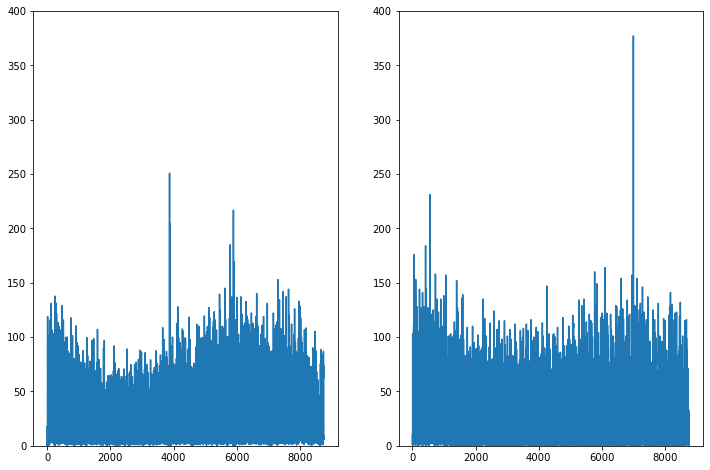

In [275]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].plot(forecast_unnorm)
ax[0].set_ylim(0,400)
ax[1].plot(next_year_data)
ax[1].set_ylim(0,400)

2021


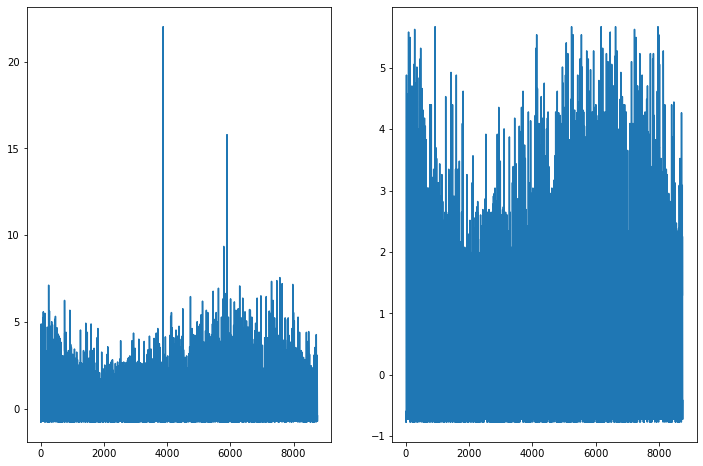

In [290]:
# Investigating outlier clipping

year = 2021
print(year)
next_year = 2022
current_year_data = full_hourly_count[full_hourly_count['Year']==year]['CaseID_norm'].values
curr_std = current_year_data.std()
clipped_current_year_data = [x if np.abs(x) < 4*curr_std else 3*curr_std for x in current_year_data]

fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].plot(current_year_data)
ax[1].plot(clipped_current_year_data)

In [ ]:
current_year_data = full_hourly_count[full_hourly_count['Year']==year]['CaseID_norm'].values
curr_std = current_year_data.std()
clipped_current_year_data = [x if np.abs(x) < 3*curr_std else 3*curr_std for x in current_year_data]

# # Need to normalize the data here
# normalized_data = scaler.fit_transform(current_year_data.reshape(-1,1)).reshape(-1)

next_year_length = len(full_hourly_count[full_hourly_count['Year']==next_year])
next_year_data = full_hourly_count[full_hourly_count['Year']==next_year]['CaseID'].values
aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=clipped_current_year_data, forecast_length=next_year_length-1, p=24, d=2)


In [297]:
# Tuning all years with normalization and outlier clipping
# This code takes 1-1.5 hours to run

all_years = np.unique(full_hourly_count['Year'].values)
full_forecast = np.array([])
orders = []
rmse_array = []
for i in range(len(all_years)-2):
    year = all_years[i]
    print(year)
    next_year = all_years[i+1]
    current_year_data = full_hourly_count[full_hourly_count['Year']==year]['CaseID_norm'].values
    curr_std = current_year_data.std()
    clipped_current_year_data = [x if np.abs(x) < 3*curr_std else 3*curr_std for x in current_year_data]
    
    next_year_length = len(full_hourly_count[full_hourly_count['Year']==next_year])
    next_year_data = full_hourly_count[full_hourly_count['Year']==next_year]['CaseID'].values
#     aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=current_year_data, forecast_length=next_year_length-1, p=24, d=2)
    aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=clipped_current_year_data, forecast_length=next_year_length-1, p=24, d=2)
    
    forecast_unnorm = scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)

    rmse = np.sqrt(mean_squared_error(forecast_unnorm, next_year_data))
    print('Test RMSE: %.3f' % rmse)
    orders.append(optimal_order)
    rmse_array.append(rmse)
    full_forecast = np.concatenate([full_forecast, forecast_unnorm])

2008
Test RMSE: 12.288
2009


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 4.759
2010


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 5.314
2011


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 5.347
2012


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 6.528
2013


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 7.991
2014
Test RMSE: 8.437
2015
Test RMSE: 13.206
2016
Test RMSE: 14.344
2017
Test RMSE: 14.990
2018
Test RMSE: 15.598
2019
Test RMSE: 16.799
2020
Test RMSE: 19.618
2021
Test RMSE: 17.453


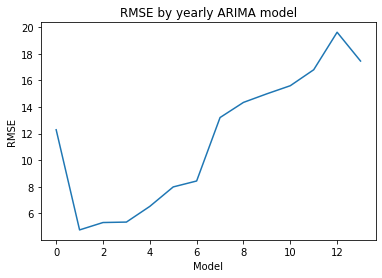

In [298]:
plt.plot(rmse_array)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE by yearly ARIMA model")
plt.show();

In [307]:
scaler.transform(full_hourly_count['CaseID'].values.reshape(-1,1)).reshape(-1)

array([-0.68349274, -0.77113203, -0.77113203, ..., -0.46439453,
       -0.28911596, -0.3329356 ])

In [316]:
scaler.inverse_transform(full_forecast.reshape(-1,1)).reshape(-1)

array([17.59786221,  2.00000381, 19.63911445, ...,  9.02716282,
        5.9112809 ,  8.65633825])

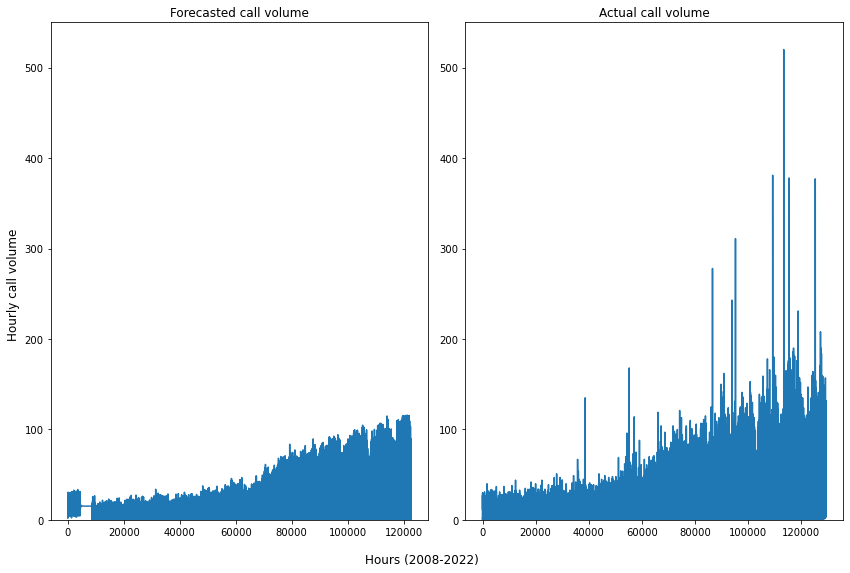

In [401]:
fig, ax = plt.subplots(1,2, figsize=(12, 8))
# ax[0].plot(full_forecast)
ax[0].plot(scaler.inverse_transform(full_forecast.reshape(-1,1)).reshape(-1))
ax[0].set_title("Forecasted call volume")
ax[1].plot(full_hourly_count['CaseID'].values)
# ax[1].plot(scaler.transform(full_hourly_count['CaseID'].values.reshape(-1,1)).reshape(-1))
ax[1].set_title("Actual call volume")
fig.supxlabel("Hours (2008-2022)")
fig.supylabel("Hourly call volume")
ax[0].set_ylim(0,550)
ax[1].set_ylim(0,550)
plt.tight_layout()
plt.savefig('figures/ARIMA_forecast_vs_actual', dpi=300)
plt.show();

In [176]:
# # Tuning all years without normalization - TO BE DELETED

# all_years = np.unique(full_hourly_count['Year'].values)
# full_forecast = np.array([])
# orders = []
# rmse_array = []
# for i in range(len(all_years)-2):
#     year = all_years[i]
#     print(year)
#     next_year = all_years[i+1]
#     current_year_data = full_hourly_count[full_hourly_count['Year']==year]['CaseID'].values
    
#     # Need to normalize the data here
    
#     next_year_length = len(full_hourly_count[full_hourly_count['Year']==next_year])
#     next_year_data = full_hourly_count[full_hourly_count['Year']==next_year]['CaseID'].values
#     aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=current_year_data, forecast_length=next_year_length-1, p=24, d=2)
    
#     forecast_unnorm = scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)

#     rmse = np.sqrt(mean_squared_error(forecast_unnorm, next_year_data))
#     print('Test RMSE: %.3f' % rmse)
#     orders.append(optimal_order)
#     rmse_array.append(rmse)
#     full_forecast = np.concatenate([full_forecast, forecast])

2008
(24, 1, 0)
Test RMSE: 5.412
2009
(24, 1, 0)
Test RMSE: 4.756
2010
(24, 1, 0)
Test RMSE: 5.313
2011
(24, 1, 0)
Test RMSE: 5.350
2012
(24, 1, 0)
Test RMSE: 6.558
2013
(24, 1, 0)
Test RMSE: 7.990
2014
(24, 1, 0)
Test RMSE: 8.463
2015
(24, 1, 0)
Test RMSE: 13.208
2016
(24, 1, 0)
Test RMSE: 14.384
2017
(24, 1, 0)
Test RMSE: 15.025
2018
(24, 1, 0)
Test RMSE: 15.766
2019
(24, 1, 0)
Test RMSE: 16.933
2020
(24, 1, 0)
Test RMSE: 19.822
2021
(24, 1, 0)
Test RMSE: 18.367


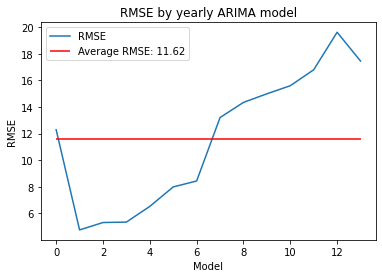

In [402]:
plt.plot(rmse_array, label='RMSE')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE by yearly ARIMA model")
average_rmse = np.mean(rmse_array)
plt.hlines(average_rmse, xmin=0, xmax=13, colors='r', label='Average RMSE: %.2f' % average_rmse)
plt.legend()
plt.savefig("figures/ARIMA_model_RMSE", dpi=300)
plt.show();

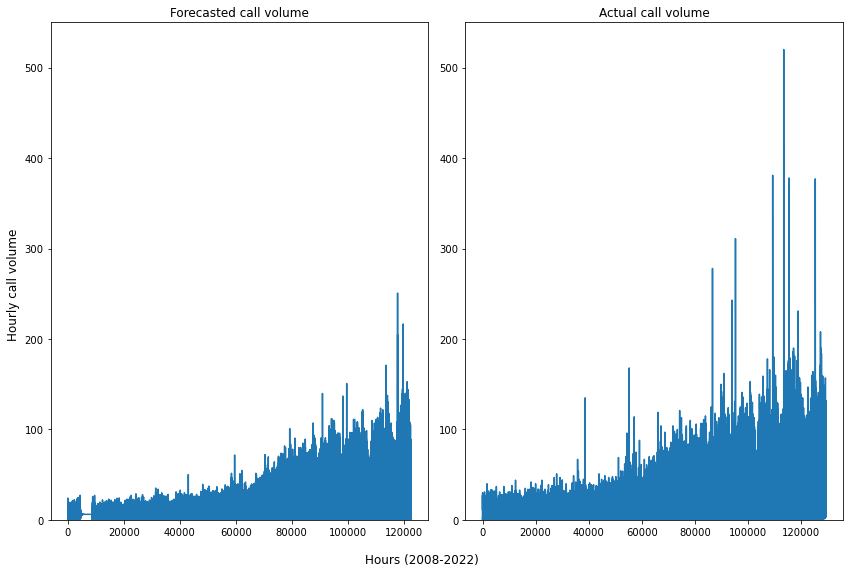

In [209]:
fig, ax = plt.subplots(1,2, figsize=(12, 8))
ax[0].plot(full_forecast)
ax[0].set_title("Forecasted call volume")
ax[1].plot(full_hourly_count['CaseID'].values)
ax[1].set_title("Actual call volume")
fig.supxlabel("Hours (2008-2022)")
fig.supylabel("Hourly call volume")
ax[0].set_ylim(0,550)
ax[1].set_ylim(0,550)
plt.tight_layout()
plt.show();

# APPENDIX

In [ ]:
models = []
forecasts = []
rmses = []
for i in range(2022-2008):
    print(i)
    train = full_hourly_count[full_hourly_count['Year']==(2008+i)]
    test = full_hourly_count[full_hourly_count['Year']==(2008+i+1)]
    model = ARIMA(train['CaseID'].values, order=(24,1,0))
    model_fit = model.fit()
#     print(model_fit.summary())
    forecast = model_fit.predict(end=len(test['CaseID'])-1)
    models.append(model)
    forecasts.append(forecast)
    rmse = np.sqrt(mean_squared_error(forecast, test['CaseID'].values))
    print('Test RMSE: %.3f' % rmse)
    rmses.append(rmse)
    
#     if i>1:
#         break

In [ ]:
# train = full_hourly_count[full_hourly_count['Year']==(2009)]
# test = full_hourly_count[full_hourly_count['Year']==(2010)]
# full_hourly_count[full_hourly_count['Year']==2009]['CaseID'].values
# model = ARIMA(train['CaseID'].values, order=(24,1,0))
# model_fit = model.fit()
# print(model_fit.summary())
# forecast = model_fit.predict(end=len(test['CaseID'])-1)
# rmse = np.sqrt(mean_squared_error(forecast, test['CaseID']))
# print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.plot(rmses)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE values of each model")
plt.show();

In [ ]:
full_hourly_count[full_hourly_count['Year']==2009]['CaseID']

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
for i in range(len(forecasts)):
    ax[0].plot(full_hourly_count[full_hourly_count['Year']==(2008+i+1)]['CaseID'].index, forecasts[i], c='b')
    ax[1].plot(full_hourly_count[full_hourly_count['Year']==(2008+i+1)]['CaseID'], \
            c='r')

fig.supxlabel("Hour")
fig.supylabel("Call volume")
fig.suptitle("ARIMA model (24,1,0)")
ax[0].set_ylim([0,550])
ax[0].set_title("Forecast call volume")
ax[1].set_ylim([0,550])
ax[1].set_title("Actual call volume")
plt.tight_layout();

In [ ]:
test = []
# for forecast in forecasts:
#     test.append(forecast.values)
#     print(forecast.shape)
#     print(forecast.values.reshape(1,-1)[0])
#     test.append(forecast.values.reshape(1,-1)[0])
    
# pd.vstack(forecasts)

plt.plot(pd.concat([forecast for forecast in forecasts], axis=0))

In [ ]:
plt.plot(rmses)

#### ARIMA (24,1,0)

In [125]:
model = ARIMA(train, order=(24,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               103508
Model:                ARIMA(24, 1, 0)   Log Likelihood             -355923.110
Date:                Thu, 20 Apr 2023   AIC                         711896.221
Time:                        10:21:11   BIC                         712134.906
Sample:                             0   HQIC                        711968.544
                             - 103508                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5432      0.001   -653.976      0.000      -0.545      -0.542
ar.L2         -0.4553      0.002   -252.635      0.000      -0.459      -0.452
ar.L3         -0.4767      0.002   -229.737      0.0

In [144]:
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 41.546


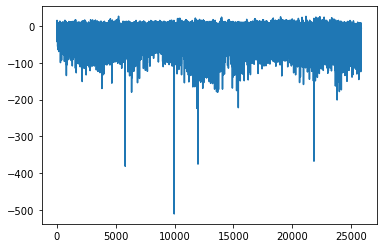

In [145]:
plt.plot(forecast-test.reshape(-1))
plt.show();

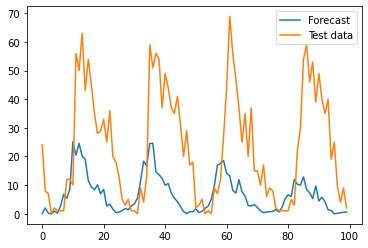

In [146]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [147]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

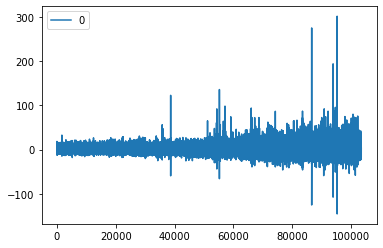

In [148]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

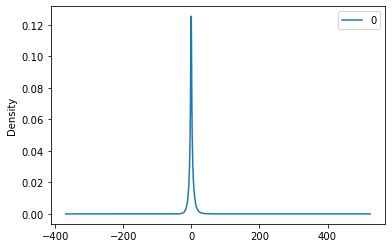

In [149]:
residuals.plot(kind='kde')

In [150]:
residuals.describe()

0
count  103508.000000
mean        0.001919
std         7.535875
min      -145.405127
25%        -2.860669
50%        -0.485139
75%         2.168056
max       301.727692

#### ARIMA (8,1,0)

In [92]:
model = ARIMA(train, order=(8,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                89855
Model:                 ARIMA(8, 1, 0)   Log Likelihood             -339307.747
Date:                Wed, 19 Apr 2023   AIC                         678633.493
Time:                        11:42:23   BIC                         678718.147
Sample:                             0   HQIC                        678659.308
                              - 89855                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1081      0.001   -112.051      0.000      -0.110      -0.106
ar.L2          0.0275      0.002     12.536      0.000       0.023       0.032
ar.L3         -0.0160      0.003     -6.348      0.0

In [93]:
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.259


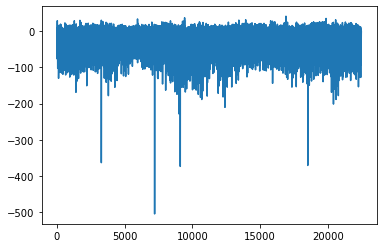

In [94]:
plt.plot(forecast-test)
plt.show();

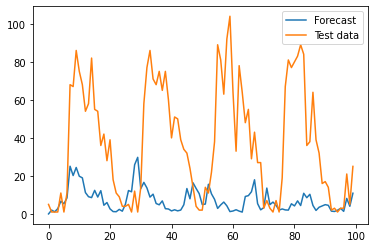

In [95]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [96]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

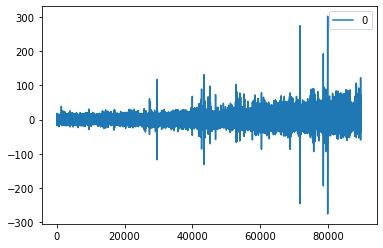

In [97]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

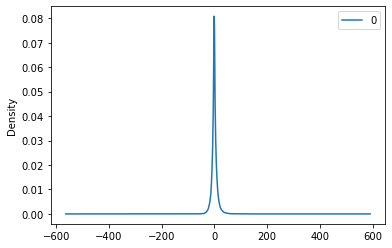

In [98]:
residuals.plot(kind='kde')

In [99]:
residuals.describe()

0
count  89855.000000
mean       0.000318
std       10.562113
min     -275.193858
25%       -4.410721
50%       -0.618449
75%        3.646356
max      301.936924

#### Trying 1

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                89855
Model:                 ARIMA(1, 1, 0)   Log Likelihood             -339794.694
Date:                Wed, 19 Apr 2023   AIC                         679593.387
Time:                        11:43:16   BIC                         679612.199
Sample:                             0   HQIC                        679599.124
                              - 89855                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1043      0.001   -108.054      0.000      -0.106      -0.102
sigma2       112.7752      0.149    757.972      0.000     112.484     113.067
Ljung-Box (L1) (Q):                   1.12   Jarque-

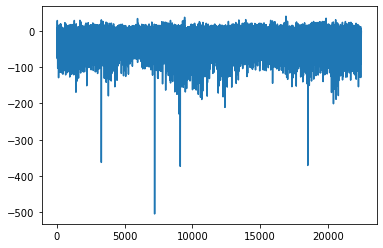

In [100]:
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)
plt.plot(forecast-test)
plt.show();

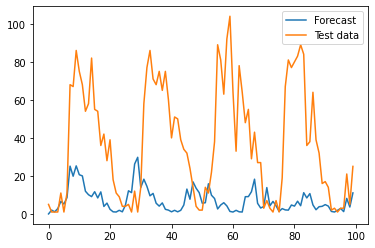

In [101]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [102]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

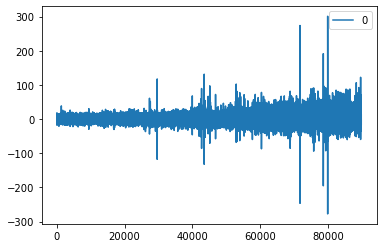

In [103]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

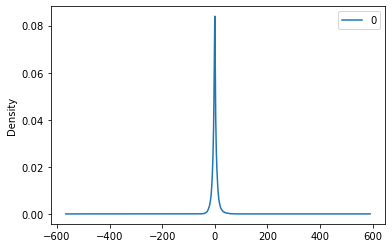

In [104]:
residuals.plot(kind='kde')

In [105]:
residuals.describe()

0
count  89855.000000
mean       0.000174
std       10.619510
min     -277.411652
25%       -4.312756
50%       -0.293543
75%        3.582992
max      301.123464

### Trying auto-arima

In [108]:
model = auto_arima(train, start_p=1, start_q=1,
                           max_p=8, max_q=2, m=1,
                           seasonal=True,
                           d=0, trace=True,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

model.fit(train)

prediction1 = model.predict(n_periods=len(train))
prediction2 = model.predict(n_periods=len(test))

#plot the predictions for validation set
# plt.plot(time_train,train, label='train')
# plt.plot(time_test,test, label='test')
# plt.plot(time_train, prediction1, label='prediction1')
# plt.plot(time_test, prediction2, label='prediction2')
# plt.legend()
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=672781.870, Time=12.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=779863.233, Time=1.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=672818.180, Time=1.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=722518.095, Time=8.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=832321.319, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=672526.585, Time=33.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=672771.065, Time=2.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=670130.373, Time=43.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=671564.356, Time=2.72 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=670090.195, Time=58.31 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=670954.866, Time=3.33 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=670022.290, Time=70.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=670633.464, Time=3.81 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=669884.176, Time=89.41 sec

In [115]:
prediction1.shape

(89855,)

In [117]:
hourly_count[split:].index.shape

(22464,)

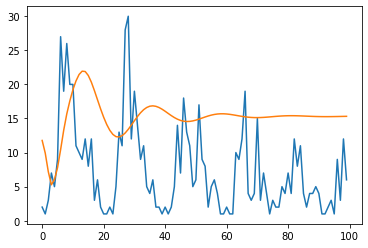

In [123]:
plt.plot(train[:100]);
plt.plot(prediction2[:100]);

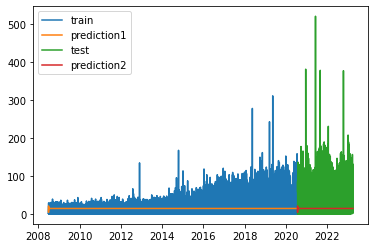

In [118]:
plt.plot(hourly_count[:split].index, train, label='train')
plt.plot(hourly_count[:split].index, prediction1, label='prediction1')
plt.plot(hourly_count[split:].index, test, label='test')
plt.plot(hourly_count[split:].index, prediction2, label='prediction2')
plt.legend()
plt.show()

### ARIMA TO-DOs
* Tune model, train/test RMSE
* Zip-code dummies
* Baseline - historical average for that date?

*Models to build:*
 * General volume
 * Garbage can overflowing
 * General cleaning
 * Bulky items
 
*Data Restrictions*
 * Use street cleaning category
 * Years: 2016-present (April 1st, 2023)

*Features to include:*
 * minute
 * day
 * hour
 * hour lags (hours 6-12)
 * ACS census tract data
 